In [1]:
import numpy as np
import warnings
import seaborn as sns
import matplotlib.pyplot as plt
import math

Note: We'll use Beta distributions for the arms as they satisfy the required properties of the reward distributions defined in the paper

<h1>Algo 1: UCB</h1>

In [6]:
#betas
K=6
# alphas = [80]+[5]*(K-1)
# betas = [20]*K

In [43]:
#arm expectations
# exp = [alphas[i]/(alphas[i]+betas[i]) for i in range(K)]

exp = [0.8,0.2, 0.2, 0.2, 0.2,0.2]                  #1good
#exp = [0.8, 0.7, 0.2, 0.2, 0.2, 0.2]               #2good
#exp = [0.8, 0.7, 0.7, 0.2, 0.2, 0.2]               #3good
#exp = [0.8, 0.7, 0.575, 0.45, 0.325, 0.2]          #arith
#exp = [0.8, 0.7, 0.512, 0.374, 0.274, 0.2]         #geom
exp

[0.8, 0.2, 0.2, 0.2, 0.2, 0.2]

In [26]:
max_exp = max(exp)
max_exp

0.8

In [ ]:
#Algorithm Cell

regrets = []
mu = np.ones(K)*np.inf
num_iter = 65535
t = np.zeros(K)
alpha = 0.2
sumreward = np.zeros(K)
# reward = np.
# for x in range(K):
#     sumreward[x] += np.random.beta(alphas[x], betas[x])
#     mu[x] = sumreward[x]
# reward[0] = np.random.beta(alphas[x], betas[x])
for i in range(1,num_iter+1):
#     print(t)
    if all(t):
        x = np.argmax([mu[k]+np.sqrt((alpha+2)*np.log(i)/(2*t[k])) for k in range(K)])
    else:
        x = np.argmax(mu)
#     x = np.argmax([mu[j]+np.sqrt((alpha+2)*np.log(i)/(2*t[j])) for j in range(K)])
    u = exp[x]
    sumreward[x] += u
    t[x]+=1
    mu[x] = sumreward[x]/t[x]
    regrets.append(max_exp - u)
    

In [ ]:
# first arm has highest sum of rewards received

sumreward

array([5.2296e+04, 6.6000e+00, 6.6000e+00, 6.6000e+00, 6.6000e+00,
       6.6000e+00])

In [ ]:
# first arm is also picked most number of times

t

array([6.537e+04, 3.300e+01, 3.300e+01, 3.300e+01, 3.300e+01, 3.300e+01])

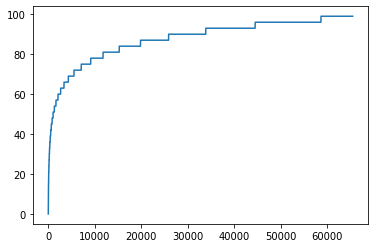

In [ ]:
plt.plot(range(num_iter), np.cumsum(regrets))

<h1>Algo 2: Doubler</h1>

In [ ]:
num_iter = 15
num_runs = 50

In [ ]:
regret_ch_doubler = np.zeros((2**num_iter-2, num_runs))
regret_un_doubler = np.zeros((2**num_iter-2, num_runs))

for it in range(num_runs):
    c = 0
    L = [np.random.choice(range(K))]
    results = []
    for i in range(1,num_iter):
        mu = np.ones(K)*np.inf
        t = np.zeros(K)
        ys = []
        sumreward = np.zeros(K)
        for j in range(1,2**i+1):
            x = np.random.choice(L)
            u = exp[x]
            if all(t):
                y = np.argmax([mu[k]+np.sqrt((alpha+2)*np.log(j)/(2*t[k])) for k in range(K)])
            else:
                y = np.argmax(mu)
            v = exp[y]
            b = np.random.choice([0,1], p=[(1 + u - v)/2, (1+v-u)/2])
            results.append(b)
            sumreward[y] += b
            t[y]+=1
            mu[y] = sumreward[y]/t[y]
            regret_ch_doubler[c][it]+=max_exp - (u*(1-b)+v*b)
            regret_un_doubler[c][it]+=max_exp - 0.5*(u+v)
            c+=1
            ys.append(y)
        L = ys
#       print(L)
        

In [ ]:
mu

array([0.51093327, 0.24806202, 0.20792079, 0.17283951, 0.20408163,
       0.21698113])

In [ ]:
# number of games won
sum(results)/len(results)

0.511475309772325

In [ ]:
#choice based regret
# plt.plot(range(c), np.cumsum(regret_ch_doubler)/num_runs, label='doubler')
# plt.plot(range(c), 50*(np.log(range(1,c+1))**2)/3, label = 'regret bound')
# plt.xlabel('time horizon')
# plt.ylabel('regret')
# plt.legend()

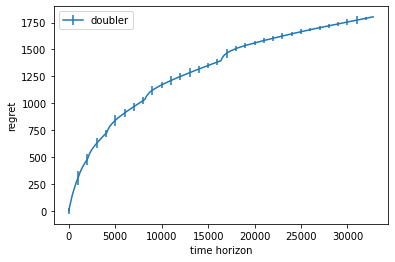

In [ ]:
plt.errorbar(range(c), np.cumsum(np.mean(regret_un_doubler, axis=1)), yerr=np.std(regret_un_doubler, axis=1)*300, errorevery = 1000, label='doubler')
# plt.plot(range(c), 50*(np.log(range(1,c+1))**2)/6, label='regret bound')
plt.xlabel('time horizon')
plt.ylabel('regret')
plt.legend()

In [ ]:
regret_un_doubler.tofile('doubler_linear_1.csv', sep = ',')       # CHANGE FILE NAME DEPENDING ON LINK FUNCTION AND EXPECTED ARM VALUES

<h1>Algo 3: Multi-SBM</h1>

In [19]:
num_iter = 32000
num_runs = 50

In [44]:
regret_ch_multi = np.zeros((num_iter, num_runs))
regret_un_multi = np.zeros((num_iter, num_runs))

alpha = 0.2

for it in range(num_runs):
    mu = np.ones((K,K))*np.inf
    t = np.zeros((K,K))
    y = np.random.choice(range(K))
    sumreward = np.zeros((K,K))
    results = []    
    for i in range(1,num_iter+1):   
        x = y
        u = exp[x]
        if all(t[x]):
            y = np.argmax([mu[x][k]+np.sqrt((alpha+2)*np.log(i)/(2*t[x][k])) for k in range(K)])
        else:
            y = np.argmax(mu[x])
        v = exp[y]
        b = np.random.choice([0,1], p=[(1 + u - v)/2, (1+v-u)/2])   # LINEAR link function
        #b = np.random.choice([0,1], p=[u/(u+v), v/(u+v)])           # NATURAL link function
        #b = np.random.choice([0,1], p=[1/(1+np.exp(v-u)), 1/(1+np.exp(u-v))])   # LOGIT link function
        regret_ch_multi[i-1][it]+=max_exp - (u*(1-b)+v*b)
        regret_un_multi[i-1][it]+=max_exp - 0.5*(u+v)
        results.append(b)
        sumreward[x][y] += b
        t[x][y]+=1
        mu[x][y] = sumreward[x][y]/t[x][y]
    

In [13]:
#number of games won
sum(results)/len(results)

0.4995

In [14]:
# choice based regret
# plt.semilogx(range(1,num_iter+1), np.cumsum(regret_ch_multi)/num_runs, label = 'algo', base=2)
# plt.semilogx(range(1,num_iter+1), 130*(np.log(range(1,num_iter+1))), label='regret bound', base=2)
# plt.legend()

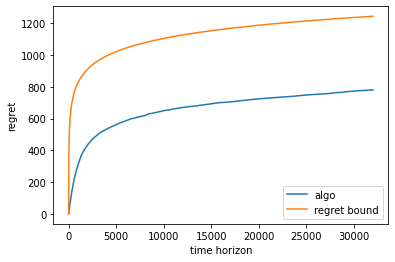

In [46]:
#plt.errorbar(range(1, num_iter+1), np.cumsum(np.mean(regret_un_multi, axis=1)), yerr=np.std(regret_un_multi, axis=1)*300, errorevery = 1000, label='MultiSBM')
plt.plot(range(1,num_iter+1), np.cumsum(np.mean(regret_un_multi, axis=1)), label = 'algo')
plt.plot(range(1, num_iter+1), 120*(np.log(range(1,num_iter+1))), label='regret bound')
plt.xlabel('time horizon')
plt.ylabel('regret')
plt.legend()

In [42]:
regret_un_multi.tofile('multisbm_linear_1.csv', sep = ',')      # CHANGE FILE NAME DEPENDING ON LINK FUNCTION AND EXPECTED ARM VALUES

Checking Loading from File

In [ ]:
regret_un_multi = np.fromfile('multisbm_linear_1.csv', sep=',').reshape(32000, 50)
plt.errorbar(range(1, num_iter+1), np.cumsum(np.mean(regret_un_multi, axis=1)), yerr=np.std(regret_un_multi, axis=1)*300, errorevery = 1000, label='MultiSBM')
regret_un_doubler = np.fromfile('doubler_linear_1.csv', sep=',').reshape(2**15-2, 50)
plt.errorbar(range(c), np.cumsum(np.mean(regret_un_doubler, axis=1)), yerr=np.std(regret_un_doubler, axis=1)*300, errorevery = 1000, label='doubler')
# plt.plot(range(1,num_iter+1), np.cumsum(np.mean(regret_un_multi, axis=1)), label = 'algo')
# plt.plot(range(1, num_iter+1), 120*(np.log(range(1,num_iter+1))), label='regret bound')
plt.xlabel('time horizon')
plt.ylabel('regret')
plt.legend()